In [16]:
"""
Created on Sat Nov 30 13:36:16 2019

@author: Talha Ilyas
"""
# Import necessary libraries
from keras.datasets import cifar10 # keras in only used for loading the data
import numpy
import time, sys
import matplotlib.pyplot as plt
import scipy.special
from tqdm import trange

In [17]:
'''
Creating the CNN class wiht all essential functions like train, test, conv, back prop etc.
'''
class CNN:
    # initialise the neural network
        '''
        Parameters
        ----------
        filter_1 : filter size for 1st conv layer [type = tuple] e.g. ->  (5,5)
        filter_2 : filter size for 2nd conv layer [type = tuple] e.g. ->  (5,5)
        input_nodes : Number of nodes in 1st hidden layer [type = int] e.g. -> 200
        h1nodes : Number of nodes in 2nd hidden layer [type = int] e.g. -> 200
        h2nodes : Number of nodes in 3rd hidden layer [type = int] e.g. -> 200
        opnodes : Number of nodes in ouput layer [type = int] equal to number of classes;
                  in case of CIFAR-10 and MNIST -> 10
        bias_hid2op : bias vector len. equal to output_nodes
        bias_hid1hid2 : bias vector len. equal to nodes_in_2nd_hidden_layer
        bias_iphid1 : bias vector len. equal to nodes_in_1st_hidden_layer
        momentum : a hyperparameter for gradient descent [type = float] e.g. ->  0.9
        BatchSize : for how many times to iterate over whole data [type = int] e.g. ->  50
        learningrate : a hyperparameter for gradient descent [type = float] e.g. ->  0.01
        decay : a hyperparameter for learning rate decay [type = float] e.g. ->  0.0001

        Returns
        -------
        None.

        '''
    def __init__(self, filter_1, filter_2, input_nodes, h1nodes, h2nodes, opnodes,
                 bias_hid2op, bias_hid1hid2, bias_iphid1, momentum, BatchSize, learningrate, decay):
    # set number of nodes in each input, hidden, output layer
        #Two Conv Filters
        self.filter1_h, self.filter1_w = filter_1
        self.filter2_h, self.filter2_w = filter_2

        self.ip_nodes = input_nodes
        self.h1_nodes = h1nodes
        self.h2_nodes = h2nodes
        self.op_nodes = opnodes

        self.bias_h2op = bias_hid2op
        self.bias_h1h2 = bias_hid1hid2
        self.bias_iph1 = bias_iphid1
        
        self.batch_size = BatchSize
        #Momentum
        self.beta = momentum
        
        self.Vdw_h2_op = 0
        self.Vdw_h1_h2 = 0
        self.Vdw_ip_h1 = 0
        
        self.Vdb_h2_op = 0
        self.Vdb_h1_h2 = 0
        self.Vdb_ip_h1 = 0
        
        self.w_ch8 = numpy.ones((8,1,1,))
        #Guassian Normal Distribution pow() means deviation in values is between +- h2_nodes**-0.5 with mean=0
        self.w_c11 = numpy.random.normal(0.0, pow(self.filter1_h, -0.5),(3,self.filter1_h, self.filter1_w))
        self.w_c12 = numpy.random.normal(0.0, pow(self.filter1_h, -0.5),(3,self.filter1_h, self.filter1_w))
        self.w_c13 = numpy.random.normal(0.0, pow(self.filter1_h, -0.5),(3,self.filter1_h, self.filter1_w))
        self.w_c14 = numpy.random.normal(0.0, pow(self.filter1_h, -0.5),(3,self.filter1_h, self.filter1_w))
        self.w_c15 = numpy.random.normal(0.0, pow(self.filter1_h, -0.5),(3,self.filter1_h, self.filter1_w))
        self.w_c16 = numpy.random.normal(0.0, pow(self.filter1_h, -0.5),(3,self.filter1_h, self.filter1_w))
        self.w_c17 = numpy.random.normal(0.0, pow(self.filter1_h, -0.5),(3,self.filter1_h, self.filter1_w))
        self.w_c18 = numpy.random.normal(0.0, pow(self.filter1_h, -0.5),(3,self.filter1_h, self.filter1_w))
        
        #2nd Layer
        self.w_c21 = numpy.random.normal(0.0, pow(self.filter2_h, -0.5),(8,self.filter2_h, self.filter2_w))
        self.w_c22 = numpy.random.normal(0.0, pow(self.filter2_h, -0.5),(8,self.filter2_h, self.filter2_w))
        self.w_c23 = numpy.random.normal(0.0, pow(self.filter2_h, -0.5),(8,self.filter2_h, self.filter2_w))
        self.w_c24 = numpy.random.normal(0.0, pow(self.filter2_h, -0.5),(8,self.filter2_h, self.filter2_w))
        self.w_c25 = numpy.random.normal(0.0, pow(self.filter2_h, -0.5),(8,self.filter2_h, self.filter2_w))
        self.w_c26 = numpy.random.normal(0.0, pow(self.filter2_h, -0.5),(8,self.filter2_h, self.filter2_w))
        self.w_c27 = numpy.random.normal(0.0, pow(self.filter2_h, -0.5),(8,self.filter2_h, self.filter2_w))
        self.w_c28 = numpy.random.normal(0.0, pow(self.filter2_h, -0.5),(8,self.filter2_h, self.filter2_w))
        
        # Linking weights
        #Guassian Normal Distribution pow() means deviation in values is between +- h2_nodes**-0.5 with mean=0
        self.w_ip_h1 = numpy.random.normal(0.0, pow(self.h1_nodes, -0.5),(self.h1_nodes, self.ip_nodes))
        self.w_h1_h2 = numpy.random.normal(0.0, pow(self.h2_nodes, -0.5),(self.h2_nodes, self.h1_nodes))
        self.w_h2_op = numpy.random.normal(0.0, pow(self.op_nodes, -0.5),(self.op_nodes, self.h2_nodes))
        #Linking Biases
        #Guassian Normal Distribution pow() means deviation in values is between +- h2_nodes**-0.5 with mean=0
        self.bias_h2_op = numpy.random.normal(0.0, pow(self.bias_h2op, -0.5),(self.bias_h2op, 1))
        self.bias_h1_h2 = numpy.random.normal(0.0, pow(self.bias_h1h2, -0.5),(self.bias_h1h2, 1))
        self.bias_ip_h1 = numpy.random.normal(0.0, pow(self.bias_iph1, -0.5),(self.bias_iph1, 1))
        
        # learning rate
        self.lr = learningrate
        self.lr_decay = decay
        
        # activation function is the sigmoid function
        self.Activate = lambda x: scipy.special.expit(x)
        pass
    #--------------------------Derivative of Activation Functions----------------------------
    
    def de_Activate(self,x):
        self.x = x * (1 - x)
        return self.x
    '''
    def Activate(self,x):
        self.x = numpy.where(x<=0, 0, x)
        return self.x
    def de_Activate(self,x):
        self.x = numpy.where(x<=0, 0, 1)
        return self.x
    '''
    #---------------Multi Layer/channel  Conv 1st filter----------------------------------------------------
    def mc_conv(self, image, flter):
        X = flter
        Y = image
        ch_f,k,l=X.shape
        ch_i,i,j=Y.shape
        Op = numpy.zeros((i-k+1,i-k+1))
        for b in range(j-l+1):
          for a in range(i-k+1):
              Op[b,a] = numpy.sum(numpy.multiply(X[:,:,:],Y[:,b:k+b,a:a+k]))    
        return Op
    #----------------multi filter output-----------------------  
    '''Op_f = numpy.stack((Op,Op), axis=0)'''
    #---------------multi filter pooling---------------------------------
    def mf_pooling(self, Op_f):
        ip = Op_f
        cd,c,d = ip.shape
        e = c-c//2
        pool = numpy.zeros((cd,e,e))
        locations = numpy.zeros((cd,e,e))
        for cd in range(cd):
            for g in range(c-e):
                for f in range(c-e):
                    pool[cd,g,f] = numpy.max(ip[cd,g*2:g+g+2,f*2:f+f+2])
                    locations[cd,g,f] = numpy.argmax(ip[cd,g*2:g+g+2,f*2:f+f+2])
        return locations,pool
    #------------------------Back Pool Multi Layer/Channel---------------------------
    def b_mf_pooling(self, before_pooling_shape,locations,pool_values):
        cache1 = pool_values
        cache2 = before_pooling_shape.shape
        cache3 = locations.astype(int)
        b_Op = numpy.zeros(cache2)
        cd,t,u = cache1.shape
        for cd in range(cd):
            for j in range(u):
                for i in range(t):
                   a = cache3[cd,j,i]
                   numpy.put(b_Op[cd,j*2:j+j+2,i*2:i+i+2],a, cache1[cd,j,i])
        return b_Op
    #---------------------Error Splitting----------------------------------------------
    '''x,y,z = numpy.split(X1,3)'''
    #-----------------------Back Conv Multi channel--------------------------------
    def b_mc_conv(self, b_pool_op, image):  
            X = b_pool_op
            Y = image
            ch_f,k,l=X.shape
            ch_i,i,j=Y.shape
            f_g = numpy.zeros((i-k+1,i-k+1))
            for b in range(j-l+1):
                for a in range(i-k+1):
                    f_g[b,a] = numpy.sum(numpy.multiply(X[:,:,:],Y[:,b:k+b,a:a+k]))
            return f_g
    #--------------------Channel wise conv----------------------------------------------------
    def ch_conv(self, f_g, pool):
            d,e,f = f_g.shape 
            a,b,c = pool.shape
            f_grad = numpy.empty((0,b-e+1,c-f+1))
            for i in range(a):
                temp = pool[i,:,:]  #taking 1 channel at a time
                temp = numpy.array(temp, ndmin=3)
                f_gad = self.b_mc_conv(f_g, temp)
                f_gad = numpy.array(f_gad, ndmin=3)
                f_grad = numpy.append(f_grad,f_gad,axis=0)
            return f_grad
    #------------------------------------------------------------ Train the CNN------------------------------------
    def train(self, inputs_list, targets_list,iteration,epoch):
        # convert inputs list to 2d array
        inputs = inputs_list
        targets = targets_list
        t = iteration
        #e = epoch
        #--------------Learning Rate Decay--------------------
        lr = self.lr
        lr *=  (1. / (1. + (self.lr_decay * t)))
        #------Conv 1 ------
        conv11_op = self.mc_conv(inputs,self.w_c11)
        conv12_op = self.mc_conv(inputs,self.w_c12)
        conv13_op = self.mc_conv(inputs,self.w_c13)
        conv14_op = self.mc_conv(inputs,self.w_c14)
        conv15_op = self.mc_conv(inputs,self.w_c15)
        conv16_op = self.mc_conv(inputs,self.w_c16)
        conv17_op = self.mc_conv(inputs,self.w_c17)
        conv18_op = self.mc_conv(inputs,self.w_c18)
        
        #-----------Making Op 1 by Stacking----------
        conv1_op = numpy.stack((conv11_op,conv12_op,conv13_op,conv14_op,conv15_op,conv16_op,conv17_op,conv18_op), axis=0)
        #------activate----
        conv1_opA = self.Activate(conv1_op)
        #------Pool 1------
        locations1,pool1_op = self.mf_pooling(conv1_opA)
        
        #---------Conv 2-----
        conv21_op = self.mc_conv(pool1_op,self.w_c21)
        conv22_op = self.mc_conv(pool1_op,self.w_c22)
        conv23_op = self.mc_conv(pool1_op,self.w_c23)
        conv24_op = self.mc_conv(pool1_op,self.w_c24)
        conv25_op = self.mc_conv(pool1_op,self.w_c25)
        conv26_op = self.mc_conv(pool1_op,self.w_c26)
        conv27_op = self.mc_conv(pool1_op,self.w_c27)
        conv28_op = self.mc_conv(pool1_op,self.w_c28)
        
        #-----------Making Op 1 by Stacking----------
        conv2_op = numpy.stack((conv21_op,conv22_op,conv23_op,conv24_op,conv25_op,conv26_op,conv27_op,conv28_op), axis=0)
        #-----Activate------
        conv2_opA = self.Activate(conv2_op)
        #-----Pool 2------
        locations2,pool2_op = self.mf_pooling(conv2_opA)
        
        #-----Flattening----------
        t = pool2_op.flatten()
        temp = pool2_op.shape
        CNN_op = t.reshape(self.ip_nodes,1)
        
        X_h1 = numpy.add(numpy.dot(self.w_ip_h1, CNN_op) , self.bias_ip_h1)
        O_h1 = self.Activate(X_h1)
        # calculate signals into hidden layer
        X_h2 = numpy.add(numpy.dot(self.w_h1_h2, O_h1) , self.bias_h1_h2)
        O_h2 = self.Activate(X_h2)
        # calculate signals into final output layer
        X_op = numpy.add(numpy.dot(self.w_h2_op, O_h2) , self.bias_h2_op)
        O_op = self.Activate(X_op)
        # output layer error is the (target - actual)
        errors_op = targets - O_op
        errors_h2 = numpy.dot(self.w_h2_op.T, errors_op)
        errors_h1 = numpy.dot(self.w_h1_h2.T, errors_h2)
        errors_ip = numpy.dot(self.w_ip_h1.T, errors_h1)
        errors_ipR = errors_ip.reshape(temp)
        
        
        errors_ipRB = self.b_mf_pooling(conv2_op, locations2, errors_ipR)
        errors_c2 = errors_ipRB #8 channel error
        
        
        errors_c2P = numpy.pad(errors_c2,((0,0),(4,4),(4,4)),'constant', constant_values=(0))
        
        w_c21F = numpy.rot90(self.w_c21,k=2)
        w_c22F = numpy.rot90(self.w_c22,k=2)
        w_c23F = numpy.rot90(self.w_c23,k=2)
        w_c24F = numpy.rot90(self.w_c24,k=2)
        w_c25F = numpy.rot90(self.w_c25,k=2)
        w_c26F = numpy.rot90(self.w_c26,k=2)
        w_c27F = numpy.rot90(self.w_c27,k=2)
        w_c28F = numpy.rot90(self.w_c28,k=2)
        
        
        errors_c11 = self.mc_conv(errors_c2P, w_c21F)
        errors_c12 = self.mc_conv(errors_c2P, w_c22F)
        errors_c13 = self.mc_conv(errors_c2P, w_c23F)
        errors_c14 = self.mc_conv(errors_c2P, w_c24F)
        errors_c15 = self.mc_conv(errors_c2P, w_c25F)
        errors_c16 = self.mc_conv(errors_c2P, w_c26F)
        errors_c17 = self.mc_conv(errors_c2P, w_c27F)
        errors_c18 = self.mc_conv(errors_c2P, w_c28F)
        
        errors_c1 =  numpy.stack((errors_c11,errors_c12,errors_c13,errors_c14,errors_c15,errors_c16,errors_c17,errors_c18), axis=0)
        
        errors_c1B = self.b_mf_pooling(conv1_op, locations1, errors_c1)#8 channel
        
        #----------------Splitting Errors to 2D for 3D------------------------
        
        self.dw_h2_op = numpy.dot((errors_op * self.de_Activate(O_op)), numpy.transpose(O_h2))
        self.dw_h1_h2 = numpy.dot((errors_h2 * self.de_Activate(O_h2)), numpy.transpose(O_h1))
        self.dw_ip_h1 = numpy.dot((errors_h1 * self.de_Activate(O_h1)), numpy.transpose(CNN_op))
        #For Biases
        self.db_h2_op = (numpy.sum(errors_op *self.de_Activate(O_op))) / self.batch_size
        self.db_h1_h2 = (numpy.sum(errors_h2 *self.de_Activate(O_h2))) / self.batch_size
        self.db_ip_h1 = (numpy.sum(errors_h1 *self.de_Activate(O_h1))) / self.batch_size
        
        self.Vdw_h2_op =  beta*self.Vdw_h2_op +(1-beta)*self.dw_h2_op
        self.Vdw_h1_h2 =  beta*self.Vdw_h1_h2 +(1-beta)*self.dw_h1_h2
        self.Vdw_ip_h1 =  beta*self.Vdw_ip_h1 +(1-beta)*self.dw_ip_h1
        
        self.Vdb_h2_op =  beta*self.Vdb_h2_op +(1-beta)*self.db_h2_op
        self.Vdb_h1_h2 =  beta*self.Vdb_h1_h2 +(1-beta)*self.db_h1_h2
        self.Vdb_ip_h1 =  beta*self.Vdb_ip_h1 +(1-beta)*self.db_ip_h1
        #------Back Conv-------------------------------------------------------------------------
        f_g2 = errors_c2 * self.de_Activate(conv2_opA)
        f_g21,f_g22,f_g23,f_g24,f_g25,f_g26,f_g27,f_g28 = numpy.split(f_g2,8)
        
        f_grad21 = self.ch_conv(f_g21,pool1_op)
        self.w_c21 += lr * f_grad21 
        
        f_grad22 = self.ch_conv(f_g22,pool1_op)
        self.w_c22 += lr * f_grad22
        
        f_grad23 = self.ch_conv(f_g23,pool1_op)
        self.w_c23 += lr * f_grad23
        
        f_grad24 = self.ch_conv(f_g24,pool1_op)
        self.w_c24 += lr * f_grad24
        
        f_grad25 = self.ch_conv(f_g25,pool1_op)
        self.w_c25 += lr * f_grad25
        
        f_grad26 = self.ch_conv(f_g26,pool1_op)
        self.w_c26 += lr * f_grad26
        
        f_grad27 = self.ch_conv(f_g27,pool1_op)
        self.w_c27 += lr * f_grad27
        
        f_grad28 = self.ch_conv(f_g28,pool1_op)
        self.w_c28 += lr * f_grad28
        
        #---------------------------------------------------------- 
        f_g1 = errors_c1B * self.de_Activate(conv1_opA)
        f_g11,f_g12,f_g13,f_g14,f_g15,f_g16,f_g17,f_g18 = numpy.split(f_g1,8)
        
        f_grad11 = self.ch_conv(f_g11,inputs)
        self.w_c11 += lr * f_grad11 
        
        f_grad12 = self.ch_conv(f_g12,inputs)
        self.w_c12 += lr * f_grad12 
        
        f_grad13 = self.ch_conv(f_g13,inputs)
        self.w_c13 += lr * f_grad13
        
        f_grad14 = self.ch_conv(f_g14,inputs)
        self.w_c14 += lr * f_grad14 
        
        f_grad15 = self.ch_conv(f_g15,inputs)
        self.w_c15 += lr * f_grad15
        
        f_grad16 = self.ch_conv(f_g16,inputs)
        self.w_c16 += lr * f_grad16 
        
        f_grad17 = self.ch_conv(f_g17,inputs)
        self.w_c17 += lr * f_grad17 
        
        f_grad18 = self.ch_conv(f_g18,inputs)
        self.w_c18 += lr * f_grad18 
        
        
        
        # update the weights for the links between the hidden and output layers
        self.w_h2_op += lr * self.Vdw_h2_op
        self.w_h1_h2 += lr * self.Vdw_h1_h2
        self.w_ip_h1 += lr * self.Vdw_ip_h1
        
        # update the biases for the links between the hidden and output layers
        self.bias_h2_op += lr * self.Vdb_h2_op
        self.bias_h1_h2 += lr * self.Vdb_h1_h2
        self.bias_ip_h1 += lr * self.Vdb_ip_h1
        
        return errors_op,lr,conv23_op,conv21_op
# query the neural network
    def query(self, inputs_list):
        # convert inputs list to 2d array
        inputs = inputs_list
        #------Conv 1 ------
        conv11_op = self.mc_conv(inputs,self.w_c11)
        conv12_op = self.mc_conv(inputs,self.w_c12)
        conv13_op = self.mc_conv(inputs,self.w_c13)
        conv14_op = self.mc_conv(inputs,self.w_c14)
        conv15_op = self.mc_conv(inputs,self.w_c15)
        conv16_op = self.mc_conv(inputs,self.w_c16)
        conv17_op = self.mc_conv(inputs,self.w_c17)
        conv18_op = self.mc_conv(inputs,self.w_c18)
        
        #-----------Making Op 1 by Stacking----------
        conv1_op = numpy.stack((conv11_op,conv12_op,conv13_op,conv14_op,conv15_op,conv16_op,conv17_op,conv18_op), axis=0)
        #------activate----
        conv1_opA = self.Activate(conv1_op)
        #------Pool 1------
        locations1,pool1_op = self.mf_pooling(conv1_opA)
        
        #---------Conv 2-----
        conv21_op = self.mc_conv(pool1_op,self.w_c21)
        conv22_op = self.mc_conv(pool1_op,self.w_c22)
        conv23_op = self.mc_conv(pool1_op,self.w_c23)
        conv24_op = self.mc_conv(pool1_op,self.w_c24)
        conv25_op = self.mc_conv(pool1_op,self.w_c25)
        conv26_op = self.mc_conv(pool1_op,self.w_c26)
        conv27_op = self.mc_conv(pool1_op,self.w_c27)
        conv28_op = self.mc_conv(pool1_op,self.w_c28)
        
        
        #-----------Making Op 1 by Stacking----------
        conv2_op = numpy.stack((conv21_op,conv22_op,conv23_op,conv24_op,conv25_op,conv26_op,conv27_op,conv28_op), axis=0)
        #-----Activate------
        conv2_opA = self.Activate(conv2_op)
        #-----Pool 2------
        locations2,pool2_op = self.mf_pooling(conv2_opA)
        #-----Flattening----------
        t = pool2_op.flatten()
        CNN_op = t.reshape(self.ip_nodes,1)

        # calculate signals into 1st hidden layer
        X_h1 = numpy.add(numpy.dot(self.w_ip_h1, CNN_op) , self.bias_ip_h1)
        O_h1 = self.Activate(X_h1)
        # calculate signals into 2nd hidden layer
        X_h2 = numpy.add(numpy.dot(self.w_h1_h2, O_h1) , self.bias_h1_h2)
        O_h2 = self.Activate(X_h2)
        # calculate signals into final output layer
        X_op = numpy.add(numpy.dot(self.w_h2_op, O_h2) , self.bias_h2_op)
        O_op = self.Activate(X_op)
        return O_op

In [18]:
'''
Define hyperparameters and load the data
'''
print(70*'=', "\nFor full data set it'll take around 1 hour one epoch maybe more!\n", 70*'=')
# No. of training and testing instances you want ot run your algorithm
X = 50000   #Training Instances
Y = 10000   #Testing Instances
# number of input, hidden and output nodes
filter_1 = (5,5)
filter_2 = (5,5)
input_nodes = 200
nodes_in_1st_hidden_layer = 40
nodes_in_2nd_hidden_layer = 40
output_nodes = 10
# learning rate
learning_rate = 0.01
decay = 0.0001
#ADAM 1st and 2nd Moments
beta = 0.9
#For scaling Bias Updates
Global_Batchsize = 1 #Fixed for this Algorithm
#Epochs -or- iteration
epochs = 5
#Data Aranging for NN Class
hidden1_nodes = nodes_in_1st_hidden_layer
hidden2_nodes = nodes_in_2nd_hidden_layer
bias_iph1 = nodes_in_1st_hidden_layer
bias_h1h2 = nodes_in_2nd_hidden_layer
bias_h2op = output_nodes
# create instance of neural network
n = CNN(filter_1, filter_2, input_nodes, hidden1_nodes,hidden2_nodes, output_nodes, bias_h2op, bias_h1h2, bias_iph1, beta, Global_Batchsize, learning_rate, decay)
# The data, split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

For full data set it'll take around 4 hours one epoch maybe more!


In [19]:
#----------------------------------Loading Training Data---------------------------------------
y_train =  numpy.reshape(y_train,(50000))
inputs_train = ((x_train / 255.0) * 0.99) + 0.01
inputs_train = numpy.reshape(inputs_train,(50000,1024,3))
targets_train = numpy.zeros([10,50000]) + 0.01
for c in range(len(y_train)):
   r = y_train[c]
   targets_train[r][c] = 0.99 
pass
inputs_small = inputs_train[0:X,:,:]
inputs_small = numpy.reshape(inputs_small,(X,1024,3))
inputs_small = inputs_small.T

targets_small = targets_train[:,0:X]

In [20]:
#------------------------------------Testing data-------------------------------------------------
inputs_test = ((x_test / 255.0) * 0.99) + 0.01
inputs_test = numpy.reshape(inputs_test,(10000,1024,3))
inputs_smalltest = inputs_test[0:Y,:,:]
inputs_smalltest = numpy.reshape(inputs_smalltest,(Y,1024,3))
inputs_smalltest = inputs_smalltest.T

test_data_label = y_test

In [21]:
#-------------------------------------------Training NN----------------------------------------------------
cost,accuracy = [],[]
plot_epoch = epochs
go1 = time.time()
for e in range(epochs):
    inputs_train_batch, targets_train_bacth = [] , []
    Batch_size = Global_Batchsize
    BS_loop = Batch_size
    Batches1 = X / Batch_size 
    Batches1 = int(Batches1)
    
    start = 0
    go2 = time.time()
    for i in trange(Batches1, desc= 'Training   Epoch {}'.format(e+1)):
        inputs_train_batch = inputs_small[:,:,start:Batch_size]
        inputs_train_batch = numpy.reshape(inputs_train_batch,(3,32,32))
        targets_train_bacth = targets_small[:, start:Batch_size]
        Errors_train,final_lr,c1_grad,c2_grad = n.train(inputs_train_batch, targets_train_bacth,i,e)
        start = Batch_size
        Batch_size = Batch_size + BS_loop
        #Cost Calculate
        Average_error = numpy.sum(Errors_train,axis=0) / 10
        Cost_func =  (1/ (2 * BS_loop)) * (sum(Average_error)**2)
        pass
    cost.append(Cost_func)
    inputs_test_batch, targets_test_bacth = [] , []
    Op3 =numpy.empty((10,0))
    Batch_size = Global_Batchsize
    BS_loop = Batch_size
    Batches2 = Y / Batch_size 
    Batches2 = int(Batches2)
    start1 = 0
#------------------------------------------Performance Measure--------------------------------------------
    for j in trange(Batches2, desc="Validating Epoch {}".format(e+1)):
        inputs_test_batch = inputs_smalltest[:,:,start1:Batch_size]
        inputs_test_batch = numpy.reshape(inputs_test_batch,(3,32,32))
        outputs = n.query(inputs_test_batch)
        start1 = Batch_size
        Batch_size = Batch_size + BS_loop
        Op3=numpy.append(Op3,outputs,axis=1)
        pass
    correct=0
    label = numpy.argmax(Op3,axis=0)
    for z in range(Y):
        if (test_data_label[z]==label[z]):
           correct+=1
    Performance = correct / Y
    print("\nAfter", e+1," Epoch Accuracy=", Performance * 100,'%\n', file=sys.stderr)
    accuracy.append(Performance)
    end2 = time.time() - go2
pass
end1 = time.time() - go1
max_performance = numpy.max(accuracy)
EPOCH = numpy.argmax(accuracy) + 1

Validating Epoch 1: 100%|████████████████████████████████████████████████████████| 10000/10000 [09:04<00:00, 18.38it/s]

After 1  Epoch Accuracy= 10.0 %

Validating Epoch 2: 100%|████████████████████████████████████████████████████████| 10000/10000 [09:09<00:00, 18.20it/s]

After 2  Epoch Accuracy= 20.84 %

Validating Epoch 3: 100%|████████████████████████████████████████████████████████| 10000/10000 [09:20<00:00, 17.83it/s]

After 3  Epoch Accuracy= 22.34 %

Validating Epoch 4: 100%|████████████████████████████████████████████████████████| 10000/10000 [08:45<00:00, 19.02it/s]

After 4  Epoch Accuracy= 23.400000000000002 %

Validating Epoch 5: 100%|████████████████████████████████████████████████████████| 10000/10000 [08:45<00:00, 19.04it/s]

After 5  Epoch Accuracy= 25.19 %



In [24]:
#------------------------------Optimizayion Algorithm & Printing------------------------
print(30*'%',"\n %  Final Result on CIFAR_10 %\n",30*'%',)
print("\nThe Optimization Algorithm was Stochastic G.D on CNN with Momentum ans L.R Decay\n")
print("Time taken for 1 Epoch        =",end2/60,'Minutes')
print("Total time taken for training =",end1/3600,'Hours')
print('Filter Size                   =',filter_1,"\nNo. of hidden Nodes=",nodes_in_1st_hidden_layer)
print ("Training Set Size  =", X, "Test Set Size=", Y, "Number of Epochs=", epochs)
print("Initial L.R         =", learning_rate,"Final L.R=", final_lr,"LR Decay",decay, "Momentum=", beta)
print("Max Performance     =", max_performance * 100,'%  at Epoch #',EPOCH)

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% 
 %  Final Result on CIFAR_10 %
 %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

The Optimization Algorithm was Stochastic G.D on CNN with Momentum ans L.R Decay

Time taken for 1 Epoch        = 78.13894874652227 Minutes
Total time taken for training = 6.66571094903681 Hours
Filter Size                   = (5, 5) 
No. of hidden Nodes= 40
Training Set Size  = 50000 Test Set Size= 10000 Number of Epochs= 5
Initial L.R         = 0.01 Final L.R= 0.001666694444907415 LR Decay 0.0001 Momentum= 0.9
Max Performance     = 25.19 %  at Epoch # 5


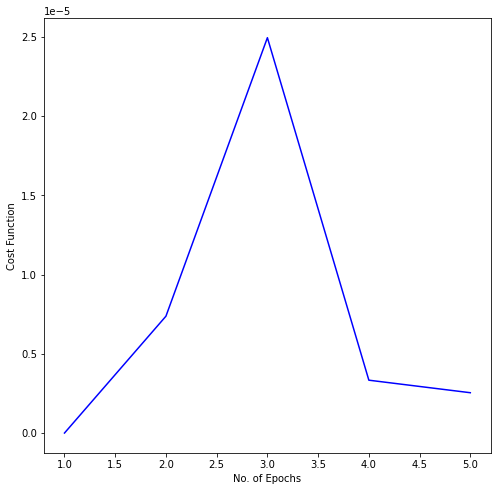

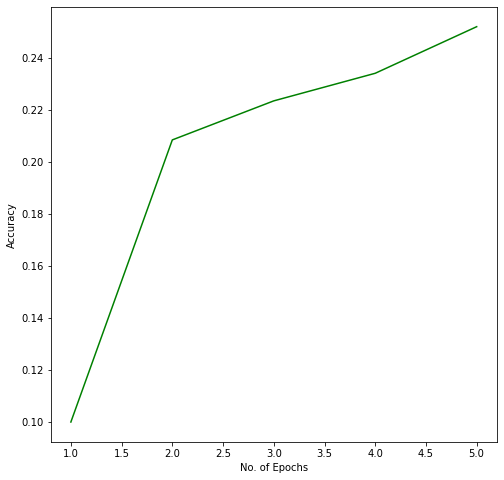

In [25]:
#-----------------------------------Plotting---------------------------------------------

plot = plot_epoch
#Learning Curve
p = numpy.linspace(1,plot_epoch,plot_epoch)
fig = plt.figure(figsize=(8,8))
plt.plot(p, cost, 'b')
plt.xlabel('No. of Epochs')
plt.ylabel('Cost Function')
plt.show()
#Performance Curve
p = numpy.linspace(1,plot_epoch,plot_epoch)
fig = plt.figure(figsize=(8,8))
plt.plot(p, accuracy, 'g')
plt.xlabel('No. of Epochs')
plt.ylabel('Accuracy')
plt.show()

#plt.imshow(c1_grad,  interpolation="nearest")
#plt.show()

